<a href="https://colab.research.google.com/github/vishal-burman/PyTorch-Architectures/blob/master/misc/Image_Search(Dual_Encoder).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip install transformers

In [68]:
import os
import collections
import json
import glob

import matplotlib.image as mpimg
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.models as models
from transformers import DistilBertModel, DistilBertTokenizer

In [ ]:
! wget http://images.cocodataset.org/annotations/annotations_trainval2014.zip

In [9]:
! unzip annotations_trainval2014.zip
! rm annotations_trainval2014.zip
! ls annotations/

captions_train2014.json   instances_val2014.json
captions_val2014.json	  person_keypoints_train2014.json
instances_train2014.json  person_keypoints_val2014.json


In [15]:
with open('annotations/captions_train2014.json', 'r') as f:
  annotations = json.load(f)['annotations']

In [ ]:
! wget http://images.cocodataset.org/zips/train2014.zip

In [ ]:
! unzip train2014.zip
! rm train2014.zip

In [26]:
image_path_to_caption = collections.defaultdict(list)
for element in annotations:
    caption = f"{element['caption'].lower().rstrip('.')}"
    image_path = "train2014" + "/COCO_train2014_" + "%012d.jpg" % (element["image_id"])
    image_path_to_caption[image_path].append(caption)

a graffiti-ed stop sign across the street from a red car 
a vandalized stop sign and a red beetle on the road
a red stop sign with a bush bumper sticker under the word stop
a stop sign that has been vandalized is pictured in front of a parked car
a street sign modified to read stop bush


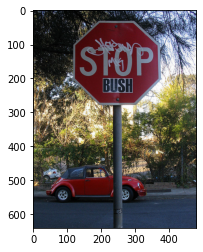

In [43]:
# Sample of the dataset

sample_image_path = image_paths[2]
img = mpimg.imread(sample_image_path)
imgplot = plt.imshow(img)

for caption in image_path_to_caption[sample_image_path]:
  print(caption)

In [44]:
captions_per_image = 2
caption_list = []
image_path_list = []
for image_path in image_paths:
    captions = image_path_to_caption[image_path][:captions_per_image]
    caption_list.extend(captions)
    image_path_list.extend([image_path] * len(captions))

In [53]:
limit = (90 * len(image_paths) // 100) * captions_per_image

train_caption_list = caption_list[:limit]
train_image_path_list = image_path_list[:limit]

valid_caption_list = caption_list[limit:]
valid_image_path_list = image_path_list[limit:]

print('Length of train samples: ', len(train_image_path_list))
print('Length of valid samples: ', len(valid_image_path_list))

Length of train samples:  149008
Length of valid samples:  16558


Caption:  an empty kitchen with white and black appliances


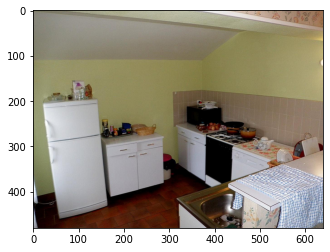

In [59]:
# Visualizing a train sample
sample_image_path = train_image_path_list[10]
img = mpimg.imread(sample_image_path)
imgplot = plt.imshow(img)

print('Caption: ', train_caption_list[10])

Caption:  a person wearing a suit talking to a child


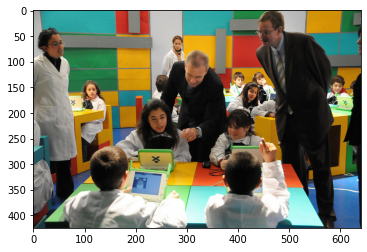

In [60]:
# Visualizing a valid sample
sample_image_path = valid_image_path_list[10]
img = mpimg.imread(sample_image_path)
imgplot = plt.imshow(img)

print('Caption: ', valid_caption_list[10])

In [61]:
# Sanity check
assert len(train_image_path_list) == len(train_caption_list)
assert len(valid_image_path_list) == len(valid_caption_list)

In [ ]:
# Loading external models

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_resnet34 = models.resnet34(pretrained=True)
model_resnet34.to(device)
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
model_distilbert = DistilBertModel.from_pretrained('distilbert-base-uncased')
model_distilbert.to(device)

In [ ]:
class CustomDataset(Dataset):
  def __init__(self, image_list, caption_list, transforms=None):
    self.image_list = image_list
    self.caption_list = caption_list
    pass
  
  def __len__(self):
    pass
  
  def __getitem__(self):
    pass

In [74]:
class VisionEncoder(nn.Module):
  def __init__(self, model, embedding_size, num_layers, dropout_rate):
    super().__init__()
    self.model = model
    self.num_layers = num_layers
    self.gelu = nn.GELU()
    self.linear_1 = nn.Linear(1000, embedding_size)
    self.linear_2 = nn.Linear(embedding_size, embedding_size)
    self.dropout = nn.Dropout(dropout_rate)
    self.layer_norm = nn.LayerNorm(embedding_size)
  
  def forward(self, x):
    projected_emb = self.linear_1(self.model(x))
    for _ in range(self.num_layers):
      x = self.gelu(projected_emb)
      x = self.linear_2(x)
      x = self.dropout(x)
      projected_emb = self.layer_norm(x)
    return projected_emb